# This is implementation with pure Keras

## Has manual feature selection. 

### Has shuffling, normalisation, udf for model training, reproducibility

Validation data is passed as some pct of the training data, for early stopping rounds. And then finally predictions are made on unseen test data.

In [1]:
# Load Keras libraries used in this example

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rn
from keras import backend as K
from sklearn.model_selection import train_test_split

# Loding data directly from Tensorflow

In [3]:
boston_housing = keras.datasets.boston_housing

In [4]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Combining the train and test data

In [5]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

train_labels = pd.DataFrame(train_labels, columns = ['label'])
train_data = pd.DataFrame(train_data, columns = column_names)

test_labels = pd.DataFrame(test_labels, columns = ['label'])
test_data = pd.DataFrame(test_data, columns = column_names)

train = pd.merge(train_data,train_labels,left_index=True,right_index=True)
test = pd.merge(test_data,test_labels,left_index=True,right_index=True)

data = train.append(test)

data.reset_index(drop=True,inplace=True)

data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,label
0,1.23247,0.0,8.14,0.0,0.5380,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.4150,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.6310,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.5150,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.7130,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7
5,0.28392,0.0,7.38,0.0,0.4930,5.708,74.3,4.7211,5.0,287.0,19.6,391.13,11.74,18.5
6,9.18702,0.0,18.10,0.0,0.7000,5.536,100.0,1.5804,24.0,666.0,20.2,396.90,23.60,11.3
7,4.09740,0.0,19.58,0.0,0.8710,5.468,100.0,1.4118,5.0,403.0,14.7,396.90,26.42,15.6
8,2.15505,0.0,19.58,0.0,0.8710,5.628,100.0,1.5166,5.0,403.0,14.7,169.27,16.65,15.6
9,1.62864,0.0,21.89,0.0,0.6240,5.019,100.0,1.4394,4.0,437.0,21.2,396.90,34.41,14.4


# Adding new features to the data

In [6]:
# Adding color of walls

list_of_colors = ['yellow','pink','green','orange','black','blue','red','white','violet','gray']

np.random.seed(seed=42)
data['color_number'] = np.random.randint(0, 10, data.shape[0])

for ind, row in data.iterrows():
    data.at[ind,'color_of_walls'] = list_of_colors[int(row.color_number)]

data.drop(['color_number'],axis=1, inplace=True)

In [7]:
# Adding whether male owner

np.random.seed(seed=42)
data['male_owner'] = np.random.choice([0,1], data.shape[0])

# Analysing the data

The dataset contains 13 different features:

Per capita crime rate. - CRIM <br>
The proportion of residential land zoned for lots over 25,000 square feet. - ZN<br>
The proportion of non-retail business acres per town. - INDUS<br>
Charles River dummy variable (= 1 if tract bounds river; 0 otherwise). - CHAS<br>
Nitric oxides concentration (parts per 10 million). - NOX<br>
The average number of rooms per dwelling. - RM<br>
The proportion of owner-occupied units built before 1940. - AGE<br>
Weighted distances to five Boston employment centers. - DIS<br>
Index of accessibility to radial highways. - RAD<br>
Full-value property-tax rate per $10,000. - TAX<br>
Pupil-teacher ratio by town. - PTRATIO<br>
1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town. - B<br>
Percentage lower status of the population. - LSTAT<br>

#### Gargabe features

Colour of walls <br>
Whether male owner <br>

#### We know that Colour of walls and Whether male owners are not good features. So, we won't pass them to the model.

# Train Test Split

In [8]:
def split_train_test(df,label_col,test_size=0.2):
    
    X = df.loc[:,df.columns != label_col]
    y = df[label_col]

    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return train_x, test_x, train_y, test_y

In [9]:
train_x, test_x, train_y, test_y = split_train_test(data,label_col='label')

# Pre Process features

It's recommended to normalize features that use different scales and ranges. For each feature, subtract the mean of the feature and divide by the standard deviation

In [10]:
def process_numerical_features(df_train,df_test,list_of_num_cols):
    
# Normalisation is done column wise
    
    for col in list_of_num_cols:
        mean = df_train[col].mean()
        std = df_train[col].std()
        
        df_train[col] = (df_train[col] - mean) / std
        df_test[col] = (df_test[col] - mean) / std
        
    return df_train,df_test

In [11]:
def process_categorical_features(df, list_of_cat_cols):

    df_temp = pd.get_dummies(df,columns=list_of_cat_cols)
    
    return df_temp

In [12]:
# Binary columns with 0/1 value
list_of_binary_cols = ['CHAS']  #----> removed male_owner
# No need of pre-processing

In [13]:
# Numerical Features

list_of_num_cols = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
train_x1, test_x1 = process_numerical_features(train_x,test_x,list_of_num_cols)

In [14]:
# Categorical features

list_of_cat_cols = [] # ---> removed color_of_walls
train_x2 = process_categorical_features(train_x1,list_of_cat_cols)
test_x2 = process_categorical_features(test_x1,list_of_cat_cols)

In [15]:
train_x2.drop(['color_of_walls','male_owner'],axis=1, inplace=True)
test_x2.drop(['color_of_walls','male_owner'],axis=1, inplace=True)

train_x2, test_x2, train_y, test_y are the pre-processed dfs.

# Create the model

Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [16]:
def build_model():
    
    model = Sequential()
    print('No of input features:', train_x2.shape[1])
    model.add(Dense(64,activation="relu",input_shape=(train_x2.shape[1],)))
    model.add(Dense(64,activation="relu"))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',
                    optimizer=RMSprop(lr=0.001),
                    metrics=[metrics.mae])
    print(model.summary())
    return model

# Train the model

In [17]:
def model_train(model, train_x, train_y, epochs=500, batch_size=100,valid_pct=0.2, early_stopping_rounds = 20,verbose=0):
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_rounds)
    
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                    validation_split=valid_pct, verbose=verbose,
                    callbacks=[early_stop])
    
    %matplotlib inline
    plot_history(history)
    
    [loss, mae] = model.evaluate(test_x2, test_y, verbose=0)

    print("Testing set Mean Abs Error: {:7.2f}".format(mae))
    print("Testing set Root Mean Sqd Error : {:7.2f}".format((loss ** 0.5)))
    
    return loss,mae

In [18]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0,5])

No of input features: 13
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
None
Testing set Mean Abs Error:    2.84
Testing set Root Mean Sqd Error :    4.58


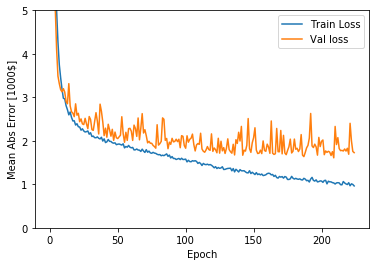

In [19]:
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

model = build_model()

loss,mae = model_train(model=model, train_x=train_x2, train_y=train_y, epochs=500, batch_size=16, valid_pct=0.2, early_stopping_rounds = 50, verbose=0)

# Predicting on the Test data

In [20]:
test_predictions = model.predict(test_x2).flatten()

In [21]:
predictions = pd.DataFrame(index=range(len(test_y)))
predictions['actual'] = pd.DataFrame(test_y.reset_index(drop=True))
predictions['preds'] = pd.DataFrame(test_predictions)

In [22]:
predictions

,actual,preds
0,18.2,19.310341
1,21.4,22.177027
2,21.5,19.133944
3,36.4,36.949097
4,20.2,19.447109
5,8.3,8.860632
6,18.7,16.718031
7,14.4,16.044518
8,23.2,21.822042
9,36.0,36.766804


In [23]:
# Mean and std of actual values in the test data.
predictions.actual.mean(), predictions.actual.std()

(22.400980392156864, 9.57748489171854)

In [24]:
# Percent error wrt to the mean actual price
print('Percent error: ',(loss ** 0.5)/predictions.actual.mean()*100,'%')

Percent error:  20.45368989290047 %


Text(0,0.5,'Predicted')

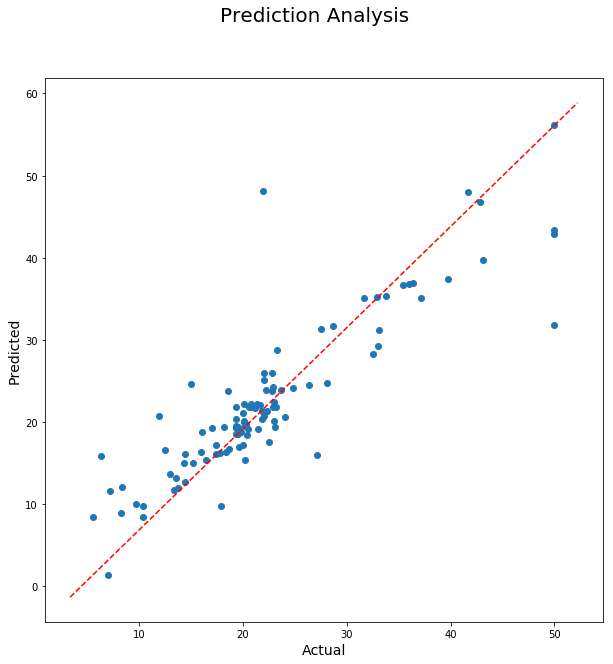

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(predictions.actual,predictions.preds)
fig.suptitle('Prediction Analysis', fontsize=20)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="r")
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)

# Conclusion

The results are better than the case when all features were passed to the model.